In [78]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [80]:
dataset = 'keypoint.csv'#'model/keypoint_classifier/keypoint.csv'
model_save_path = 'keypoint_classifier.hdf5'#'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'#'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [82]:
NUM_CLASSES = 5

# Dataset reading

In [84]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [86]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [90]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [92]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [96]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [98]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

00
7/7 [==============================] - 0s 11ms/step - loss: 0.4877 - accuracy: 0.8135 - val_loss: 0.2975 - val_accuracy: 0.9574

Epoch 00224: saving model to keypoint_classifier.hdf5
Epoch 225/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.5353 - accuracy: 0.7801 - val_loss: 0.2945 - val_accuracy: 0.9535

Epoch 00225: saving model to keypoint_classifier.hdf5
Epoch 226/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.5147 - accuracy: 0.7994 - val_loss: 0.2904 - val_accuracy: 0.9225

Epoch 00226: saving model to keypoint_classifier.hdf5
Epoch 227/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.5495 - accuracy: 0.7713 - val_loss: 0.2880 - val_accuracy: 0.9109

Epoch 00227: saving model to keypoint_classifier.hdf5
Epoch 228/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.5115 - accuracy: 0.7808 - val_loss: 0.2853 - val_accuracy: 0.9264

Epoch 00228: saving model to keypoint_classifier.hdf5
Epoch 229/1000
7/7 [==

In [100]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 4ms/step - loss: 0.2253 - accuracy: 0.9922


In [101]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [102]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[6.8502140e-01 1.4378978e-03 2.9750947e-06 4.0897470e-05 3.1349692e-01]
0


# Confusion matrix

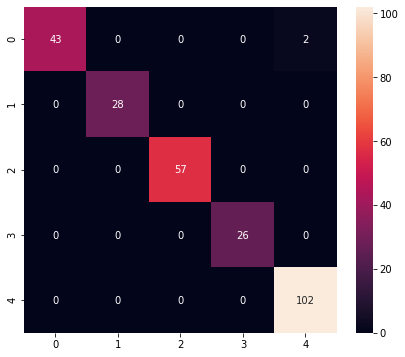

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        26
           4       0.98      1.00      0.99       102

    accuracy                           0.99       258
   macro avg       1.00      0.99      0.99       258
weighted avg       0.99      0.99      0.99       258



In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [104]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [105]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpsytvnuta/assets
INFO:tensorflow:Assets written to: /tmp/tmpsytvnuta/assets


6464

# Inference test

In [106]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [107]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [108]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [109]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 48 µs, sys: 4 µs, total: 52 µs
Wall time: 57.2 µs


In [110]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.8502146e-01 1.4378973e-03 2.9750950e-06 4.0897434e-05 3.1349680e-01]
0
